<a href="https://colab.research.google.com/github/bijitdeb/Course/blob/master/Twiiter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#libraries being used
#re: for using Regex Expression
#np, pd : python libraries
#Nltk : Natural Language Toolkit for language processing
#sklearn: for using required machine learning models
#seaborn: python data visualization based on metaplotlib

In [14]:
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer

import nltk
from bs4 import BeautifulSoup
import re,string
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/content/drive/My Drive/Twitter Feed/Project_Data.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.tail(5)

Mounted at /content/drive


,target,ids,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [4]:
# Next, let’s get the count of the null values before proceeding to the pre-processing of the text. You will see that the number of null values is zero, so there is no need to clean the data set.

np.sum(df.isnull().any(axis=1))

0

In [5]:
# Let’s get a sense of the data set. The command below will help you understand what the data set looks like

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
# We mainly need to process the data for the tweet column, which is the text column, and the target column, which is the negative/positive sentiment. Let’s take the two columns for further analysis.

data=df[['text','target']]

In [7]:
# Further, we know that the positive tweet is represented by “4.” Let’s replace it with 1. So, now the positive tweet is represented by 1 and the negative tweet by 0.

data['target'] = data['target'].replace(4,1)

<ipython-input-7-c350880468d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [8]:
# Now, let’s separate the positive and negative tweets and take only 10,000 rows to perform the analysis

data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

data_pos = data_pos.iloc[:int(10000)]
data_neg = data_neg.iloc[:int(10000)]

In [9]:
# Further, let’s combine these 10,000 positive and negative tweets. We segregated these tweets to get the equal amount of both positive and negative tweets and hence ensured that the training of the model is not biased.

dataset = pd.concat([data_pos, data_neg])

In [10]:
# Let’s now convert the text into lowercase to eliminate the casing variation.

dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

9995                                      aww that's sad 
9996      stupid dvds stuffing up the good bits in jaws. 
9997    @dandy_sephy no. only close friends and family...
9998    crap! after looking when i last tweeted... why...
9999                            its another rainboot day 
Name: text, dtype: object

In [11]:
# Let’s now define a set of stop words, which will be removed from the text, as they are of the least importance and are just present for grammatical correctness.

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [12]:
# Now, remove the stop words from the text column.

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].tail()

9995                                       aww that's sad
9996                 stupid dvds stuffing good bits jaws.
9997    @dandy_sephy no. close friends family i'm afra...
9998    crap! looking last tweeted... early. it's 10! ...
9999                                 another rainboot day
Name: text, dtype: object

In [15]:
# Now, let’s use the concept of regular expression to remove the URLs and numbers from the text to clean it further.

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].head()

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].head()

800000                 love @healthuandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                       @lovesbrooklyn effect everyone
Name: text, dtype: object

In [16]:
# Now, we must tokenize the texts. This can be done using the NLTK library

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].tail()

9995                                  [aww, that, s, sad]
9996           [stupid, dvds, stuffing, good, bits, jaws]
9997    [dandy_sephy, no, close, friends, family, i, m...
9998    [crap, looking, last, tweeted, early, it, s, s...
9999                             [another, rainboot, day]
Name: text, dtype: object

In [17]:
# Now let’s apply stemming and lemmatization, which brings the words in various forms to their base form

#stemming
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

#Lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

Let's get started with the model building:

In [18]:
# Let’s separate X and Y, the input feature, and the label.

X=data.text

y=data.target

In [19]:
# The next step involves splitting the data into train and test data sets. We are splitting it in a 95 to 5 ratio.

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

In [21]:
# Now using the TFIDF method, we will get the feature words, which will be the basis for building the model.

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)

vectoriser.fit(X_train)

print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


In [23]:
# Now, we will transform X_train and X_test using the TFIDF vectorizer

X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)


In [25]:
# Before starting the model-building and evaluation process, let’s define a function that will perform model evaluation. We will evaluate based on precision, recall, confusion matrix, etc. This is just evaluation code; you need not understand it in detail.

def model_Evaluate(model):

  # Predict values for Test dataset

  y_pred = model.predict(X_test)

  # Print the evaluation metrics for the dataset.

  print(classification_report(y_test, y_pred))

  # Compute and plot the Confusion matrix

  cf_matrix = confusion_matrix(y_test, y_pred)

  categories = ['Negative','Positive']

  group_names = ['True Neg','False Pos', 'False Neg','True Pos']

  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]

  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',

  xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)

  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)

  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           1       0.80      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



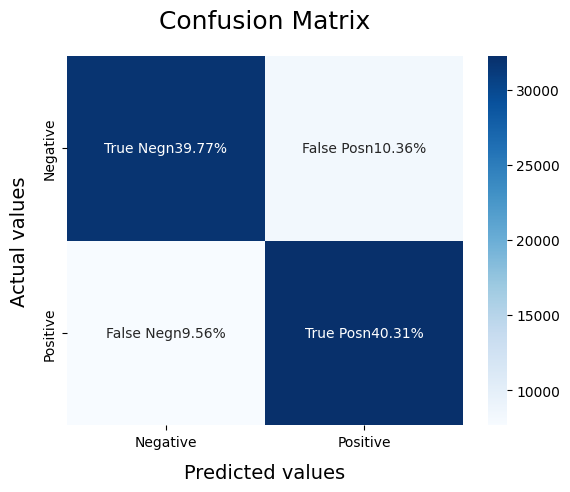

In [26]:
# Next, let’s use the Bernoulli Naive Bayes model for model-building. Let’s fit the model.
# About Naive Bayes: The Naïve Bayes algorithm is a supervised learning algorithm based on the Bayes’ theorem. It is used for solving classification problems.

BNBmodel = BernoulliNB()

BNBmodel.fit(X_train, y_train)

model_Evaluate(BNBmodel)

y_pred1 = BNBmodel.predict(X_test)